# 製作因子分析表
1. 拉因子進表單中
2. 計算不同decay的IC值
3. 畫不同群的損益(優~劣 / 持有不同天數)

先用樣本內2006~2012，樣本外2013~2022試試看最佳化

In [257]:
import pymongo
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
from typing import Union, Optional


In [258]:
class Factor:

    def __init__(self, client: pymongo.MongoClient, start: datetime.datetime, end: datetime.datetime, db_name: str='Fields'):
        self.client = client
        self.start = start
        self.end = end
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()

        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', 50)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')


    def get_chart(self):
        keys = self.results
        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()

    def get_data_list(self):
        return self.db.list_collection_names()
    
    def get_data(self, name: Union[str, list], start: Optional[datetime.datetime]=None, end: Optional[datetime.datetime]=None, store: bool=True):
        """
        name: str, list 要取得的表單名稱
        
        """
        if start == None:
            start = self.start
        if end == None:
            end = self.end

        if type(name) == list:
            for n in name:
                df = pd.DataFrame(self.db[n].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
                self.data[n] = df
        else:
            df = pd.DataFrame(self.db[name].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0})).set_index('日期')
            if store:
                
                self.data[name] = df
            else:
                return df
    
    def create_to_daily(self, df: pd.DataFrame):
        """
        將日以上週期資料轉換為日資料
        """
        if '收盤價' not in self.data.keys():
            self.get_data('收盤價')
        idx = self.data['收盤價'].index
        col = self.data['收盤價'].columns
        n = pd.DataFrame(columns=col.intersection(df.columns), index=idx.union(df.index))
        for i in n.index:
            for c in n.columns:
                try:
                    n.at[i, str(c)] = df.at[i, c]
                except:
                    pass
                
        return n.fillna(method='ffill').loc[idx, col]

    def get_norm_factor(self, name: Union[str, list]):
        if type(name) == list:
            for n in name:
                if n in self.data.keys():
                    df = self.data[n]
                else:
                    df = pd.DataFrame(self.db[n].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        else:
            if name in self.data.keys():
                df = self.data[name]
            else:
                df = pd.DataFrame(self.db[name].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0).replace([np.inf, -np.inf], 0)

    def get_ic(self, df: pd.DataFrame, pct_len: int=20, decay: int=1):
        """
        df: 放要算IC的資料
        pct_len: 與df計算IC的還原收盤價，是用多長時間的報酬，DEFAULT:20 = 一個月報酬
        decay: 位移距離，DEFAULT=1表示移一格
        """
        if '還原收盤價' in self.data.keys():
            close = self.data['還原收盤價']
        else:
            close = pd.DataFrame(self.db['還原收盤價'].find({"日期": {'$gt': self.start, '$lt': self.end}}, {'_id': 0})).set_index('日期')
        idx = df.index.intersection(close.index)
        col = df.columns.intersection(close.columns)
        df_ = df.copy()
        df_ = df_.loc[idx, col]
        close = close.loc[idx, col].pct_change(pct_len).shift(-decay)
        ic = df_.corrwith(close, axis=1)
        
        return ic


In [276]:
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2013, 1, 1)
factor = Factor(pymongo.MongoClient(), start=start, end=end, db_name='Fields')
factor.get_data(['開盤價', '最高價', '最低價', '還原收盤價', 'EPS_Q'], store=True)

In [260]:
ic_EPS_Q = factor.get_ic(factor.create_to_daily(factor.get_norm_factor('EPS_Q').pct_change()))
ic_預估EPS_Q = factor.get_ic(factor.create_to_daily(factor.get_norm_factor('預估EPS_Q').pct_change()))
ic_營業收入淨額_Q = factor.get_ic(factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y').pct_change()))
ic_殖利率 = factor.get_ic(factor.get_norm_factor('殖利率'))
ic_股價淨值比 = factor.get_ic(factor.get_norm_factor('股價淨值比'))
ic_本益比 = factor.get_ic(factor.get_norm_factor('本益比'))
ic_成交金額 = factor.get_ic(factor.get_norm_factor('成交金額(千)'))
#ic_60MA = factor.get_ic(factor.get_norm_factor('本益比'))

#pct_change = factor.data['還原收盤價'].pct_change(20)


In [277]:
factors = {
    'EPS_Q': factor.create_to_daily(factor.get_norm_factor('EPS_Q').pct_change()),
    '營業收入淨額_Y': factor.create_to_daily(factor.get_norm_factor('營業收入淨額_Y').pct_change()),
    '殖利率': factor.get_norm_factor('殖利率'),
    '股價淨值比': factor.get_norm_factor('股價淨值比'),
    '本益比': factor.get_norm_factor('本益比'),
    '成交金額(千)': factor.get_norm_factor('成交金額(千)'),
    '60MA': factor.data['還原收盤價'].rolling(60).mean().pct_change(),
    '120MA': factor.data['還原收盤價'].rolling(120).mean().pct_change()
}

2022-10-03 00:30:20.043602
0.0009530606432045269
{'EPS_Q': -9, '營業收入淨額_Y': 8, '殖利率': 5, '股價淨值比': 7, '本益比': -6, '成交金額(千)': -5, '60MA': 3, '120MA': 3}


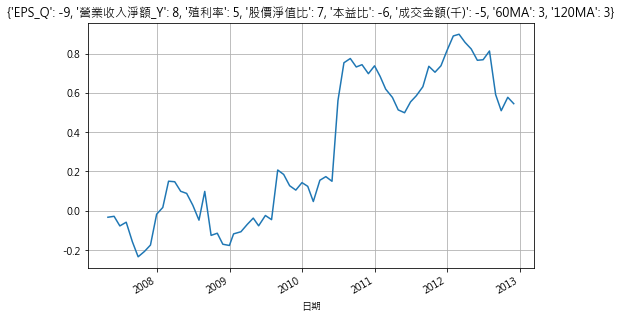

0.015357052539239613
{'EPS_Q': -9, '營業收入淨額_Y': -7, '殖利率': 4, '股價淨值比': 3, '本益比': 0, '成交金額(千)': -10, '60MA': -7, '120MA': -5}


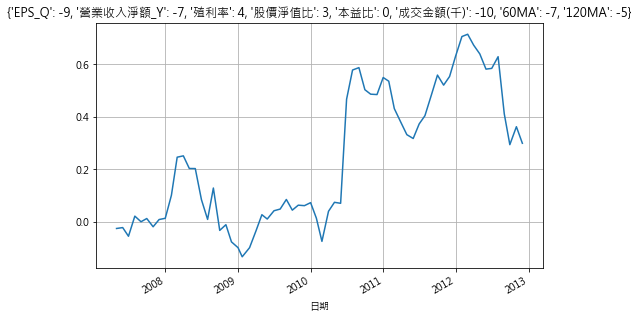

0.14164790494598412
{'EPS_Q': -7, '營業收入淨額_Y': -1, '殖利率': 7, '股價淨值比': 2, '本益比': -1, '成交金額(千)': 6, '60MA': 4, '120MA': -8}


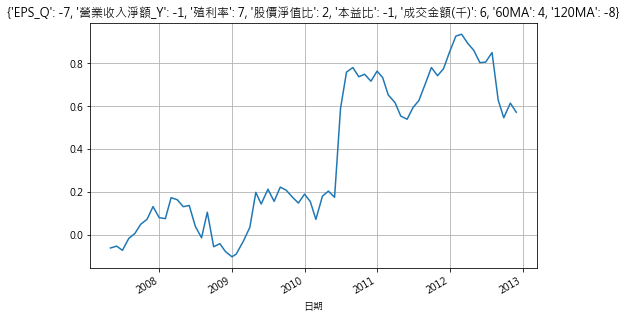

0.21553835006042327
{'EPS_Q': -6, '營業收入淨額_Y': -9, '殖利率': 4, '股價淨值比': -4, '本益比': 9, '成交金額(千)': 8, '60MA': 7, '120MA': -9}


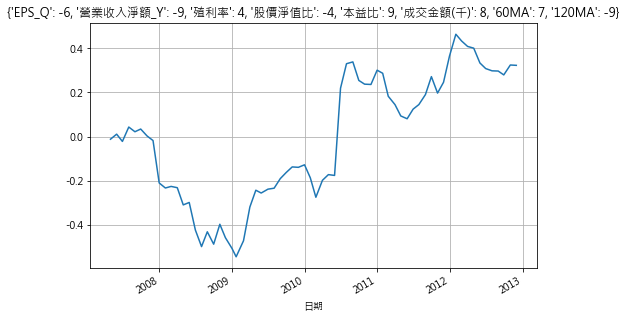

0.32097780482769317
{'EPS_Q': -6, '營業收入淨額_Y': 1, '殖利率': -4, '股價淨值比': 4, '本益比': 7, '成交金額(千)': 8, '60MA': 2, '120MA': 3}


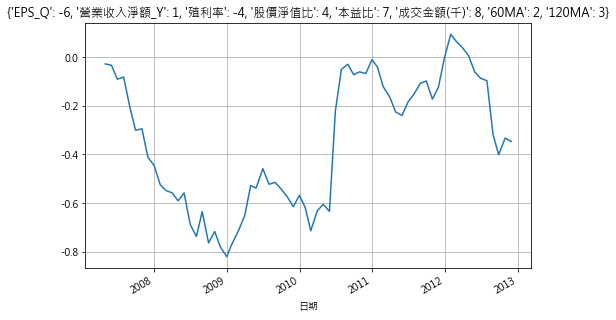

0.4259054276220856
{'EPS_Q': -3, '營業收入淨額_Y': -4, '殖利率': -8, '股價淨值比': -1, '本益比': -9, '成交金額(千)': 9, '60MA': -3, '120MA': -5}


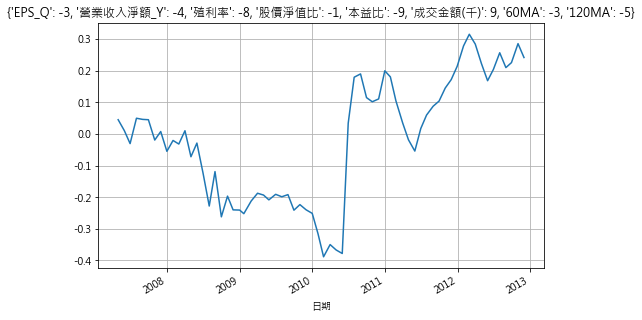

0.5991829686228154
{'EPS_Q': -1, '營業收入淨額_Y': -4, '殖利率': -7, '股價淨值比': 0, '本益比': 0, '成交金額(千)': 7, '60MA': -10, '120MA': 3}


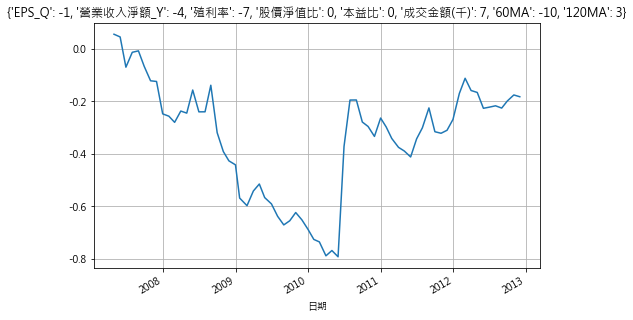

0.7258825102917728
{'EPS_Q': -1, '營業收入淨額_Y': 3, '殖利率': -8, '股價淨值比': 9, '本益比': -3, '成交金額(千)': 7, '60MA': 6, '120MA': -1}


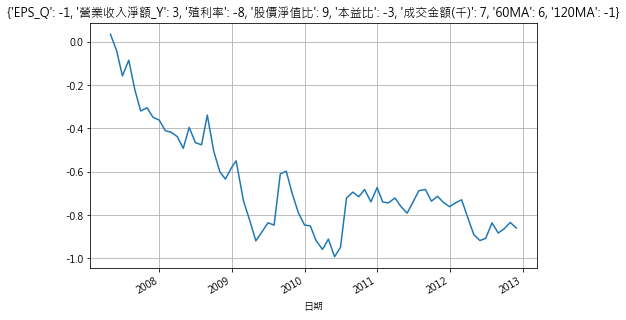

0.8722876358965371
{'EPS_Q': 0, '營業收入淨額_Y': 2, '殖利率': -6, '股價淨值比': 4, '本益比': 1, '成交金額(千)': 7, '60MA': -2, '120MA': 5}


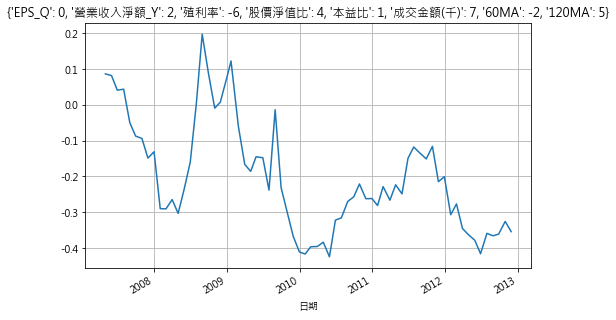

0.9282066332724594
{'EPS_Q': 0, '營業收入淨額_Y': 1, '殖利率': -8, '股價淨值比': 9, '本益比': 3, '成交金額(千)': 4, '60MA': 4, '120MA': 3}


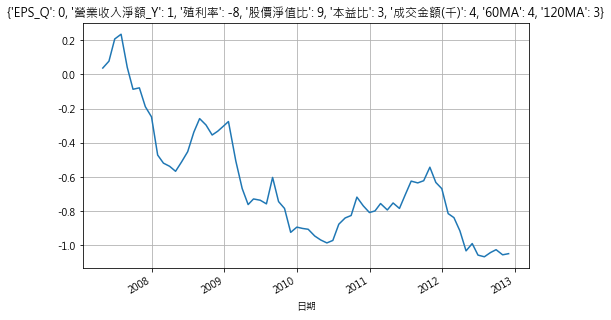

0.9337784946247042
{'EPS_Q': 0, '營業收入淨額_Y': -2, '殖利率': 3, '股價淨值比': 7, '本益比': 6, '成交金額(千)': 9, '60MA': -6, '120MA': -9}


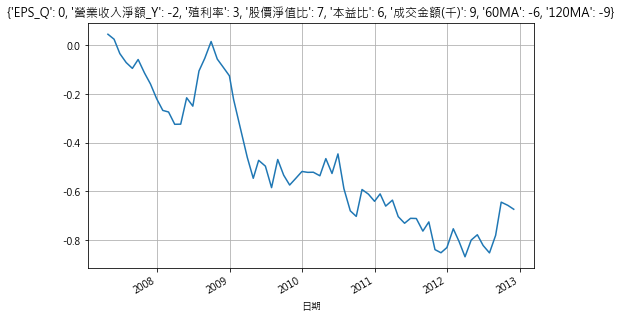

0.9554154027078802
{'EPS_Q': 0, '營業收入淨額_Y': -3, '殖利率': -1, '股價淨值比': 5, '本益比': -1, '成交金額(千)': 4, '60MA': -4, '120MA': 8}


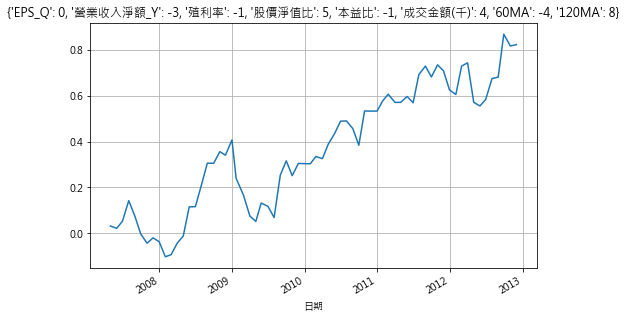

0.9973172027681261
{'EPS_Q': 0, '營業收入淨額_Y': -1, '殖利率': 0, '股價淨值比': 6, '本益比': 2, '成交金額(千)': 4, '60MA': -6, '120MA': 8}


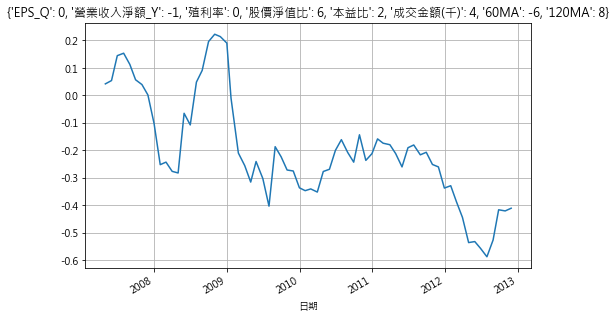

1.0116807381297883
{'EPS_Q': 0, '營業收入淨額_Y': -1, '殖利率': -6, '股價淨值比': 9, '本益比': -6, '成交金額(千)': 9, '60MA': -2, '120MA': 8}


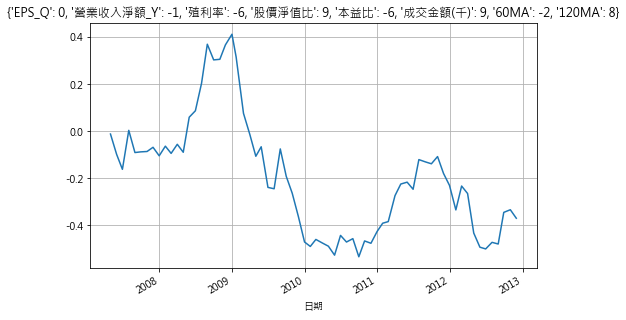

2022-10-03 05:32:04.289967
1.0116807381297883
{'EPS_Q': 0, '營業收入淨額_Y': -1, '殖利率': -6, '股價淨值比': 9, '本益比': -6, '成交金額(千)': 9, '60MA': -2, '120MA': 8}


In [289]:
print(datetime.datetime.now())
best_ir = 0
best_weights = dict()
for _ in range(10000):
    weights = {
        'EPS_Q': np.random.randint(-10, 10),
        '營業收入淨額_Y': np.random.randint(-10, 10),
        '殖利率': np.random.randint(-10, 10),
        '股價淨值比': np.random.randint(-10, 10),
        '本益比': np.random.randint(-10, 10),
        '成交金額(千)': np.random.randint(-10, 10),
        '60MA':  np.random.randint(-10, 10),
        '120MA':  np.random.randint(-10, 10)
    }

    multifactor = dict()
    for k in factors.keys():
        multifactor[k] = factors[k] * weights[k]
    ic_multifactor = factor.get_ic(sum(multifactor.values()), pct_len=20, decay=4)
    ir = ic_multifactor.mean() / ic_multifactor.std()
    group_names = [str(x) for x in range(1, 201)]
    if ir > best_ir:
        best_ir = ir
        best_weights = weights
        print(best_ir)
        print(best_weights)
        # 分群計算
        #group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
        #group_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12' ,'13', '14', '15']
        multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
        close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1).pct_change().shift(-1)
        df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
        for idx, row in multifactor_m.iterrows():
            # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
            se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
            if len(row.dropna()) >= 5:
                df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 200, labels=group_names)).mean()
        # 買第五群(最高分) 賣第一群(最低分)
        (df_group_results['200'] - df_group_results['1']).cumsum().plot(figsize=(8, 5), grid=True, title=str(best_weights))
        plt.show()
        #df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
print(datetime.datetime.now())
print(best_ir)
print(best_weights)

In [285]:
str(best_weights)

"{'EPS_Q': -3, '營業收入淨額_Y': -4, '殖利率': 9, '股價淨值比': 9, '本益比': -6, '成交金額(千)': 3, '60MA': 6, '120MA': 9}"

In [278]:
multifactor = dict()
for k in factors.keys():
    multifactor[k] = factors[k] * best_weights[k]

<AxesSubplot:xlabel='日期'>

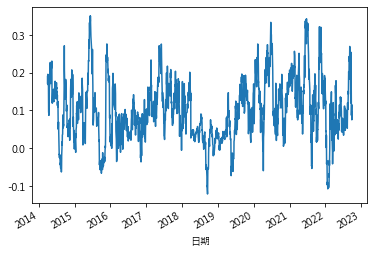

In [263]:
ic_multifactor = factor.get_ic(sum(multifactor.values()), pct_len=20)
ic_multifactor.plot()

In [264]:
def group_score(df):
    group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']#, '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
    index = 收盤價.index.intersection(df.index)
    pf = 收盤價.loc[index]
    pf = pf.groupby(pd.Grouper(freq='1m')).tail(1)
    pf = pf.pct_change().shift(-1)
    df_n = df.loc[index]
    df_m = df_n.groupby(pd.Grouper(freq='1m')).tail(1)
    pf = pf.loc[:, pf.columns.intersection(df_m.columns)]
    df_m = df_m.loc[:, pf.columns.intersection(df_m.columns)]
    df_group_results = pd.DataFrame(index=pf.index, columns=group_names)
    for idx, row in df_m.iterrows():
        se = pd.Series(pf.loc[idx, row.index] - 0.00425, name=idx)
        if len(row.dropna()) >= 5:
            df_group_results.loc[idx] = se.groupby(pd.cut(row.dropna(), 5, labels=group_names)).mean()
    df_group_results.cumsum().plot(figsize=(16, 9), grid=True)
    return df_group_results

group_score(PB.fillna(PB.mean()).dropna(how='all'))

NameError: name 'PB' is not defined

<AxesSubplot:xlabel='日期'>

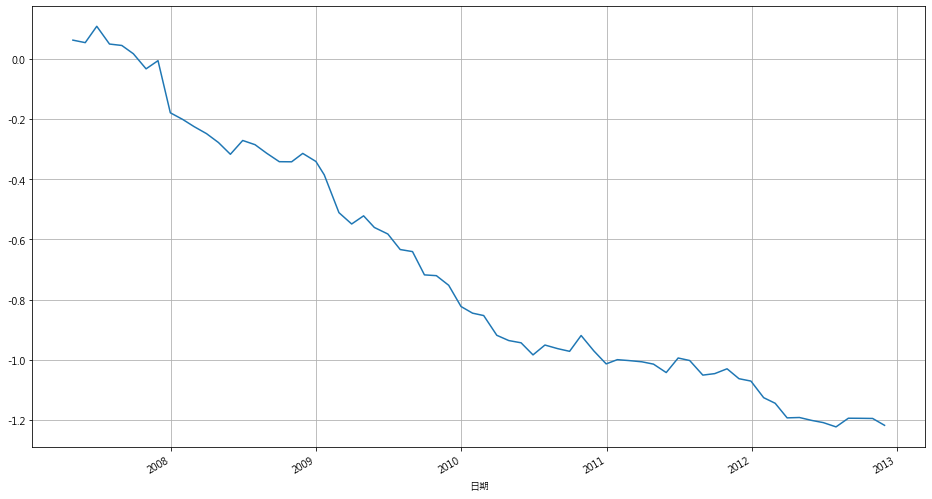

In [280]:
# 分群計算
group_names = ['first quantile', 'second quantile', 'third quantile', 'fourth quantile', 'fifth quantile']
group_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12' ,'13', '14', '15']
multifactor_m = pd.DataFrame(sum(multifactor.values())).fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1)
close_m = factor.data['還原收盤價'].fillna(method='ffill').groupby(pd.Grouper(freq='1m')).tail(1).pct_change().shift(-1)
df_group_results = pd.DataFrame(index=multifactor_m.index, columns=group_names)
for idx, row in multifactor_m.iterrows():
    # 如果都收盤買賣，不會滑價 每次進出場就是0.001425+0.001425+0.003
    se = pd.Series(close_m.loc[idx, :] - 0.00550, name=idx)
    if len(row.dropna()) >= 5:
        df_group_results.loc[idx, :] = se.groupby(pd.qcut(row, 15, labels=group_names)).mean()
# 買第五群(最高分) 賣第一群(最低分)
(df_group_results['15'] - df_group_results['1']).cumsum().plot(figsize=(16, 9), grid=True)
#df_group_results.cumsum().plot(figsize=(16, 9), grid=True)

In [250]:
multifactor_m.loc['2009-03-31', :][pd.qcut(multifactor_m.loc['2009-03-31', :], 5, labels=group_names) == 'fifth quantile']
#df_group_results.loc['2009', :]

1201    58.4453
1217    48.2781
1235    35.6057
1301   202.4282
1303    51.1450
         ...   
8299   106.3560
8933    27.9558
9904   232.0649
9927    26.7967
9935    39.2830
Name: 2009-03-31 00:00:00, Length: 208, dtype: float64

In [ ]:
class Chast:

    def __init__(self, client, db_name='Data'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        


    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1]


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, e, start: datetime.datetime, end: datetime.datetime):
        """
        e: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        collection = self.db.list_collection_names()

        if type(e) != list:
            df = list()
            for c in collection:
                err = list()
                try:
                    se = pd.DataFrame(self.db[c].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, e: 1})).set_index('日期')
                    se.columns = [c]
                    se = se.loc[se.index.dropna()]
                    df.append(se)
                except Exception as exc:
                    err.append((c, exc))
            print(err)
            self.data[e] = pd.concat(df, axis=1).fillna(method='ffill')
        else:
            for ee in e:
                df = list()
                for c in collection:
                    err = list()
                    try:
                        se = pd.DataFrame(self.db[c].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, ee: 1})).set_index('日期')
                        se.columns = [c]
                        se = se.loc[se.index.dropna()]
                        df.append(se)
                    except Exception as exc:
                        err.append((c, exc))
                print(ee, err)
                self.data[ee] = pd.concat(df, axis=1).fillna(method='ffill')
                

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca